# Generate new pre-processed spiral true posterior
We empirically generated true spiral posterior derived from the Monte Carlo simulation of base Gaussian parity experiment. The data is converted and pre-processed as previously done.

In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias


## Load packages

In [2]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf/SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf/PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf/TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf/EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf/HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


In [3]:
ib.load_sampledData()

[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf/SampledData.pickle ] loaded


## Time and Date of the experiment

In [4]:
print(ib.date)

2022-01-26 04:24:58.126235


## Load dependencies

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from scipy import spatial

cmap = 'PRGn'

import warnings
warnings.filterwarnings('ignore')

#image output
import os
import imageio

#### Load new spiral posterior

In [6]:
ns = pd.read_csv('dat/spiral_pdf.csv', index_col=0) #new spiral
ns = ns.to_numpy()

#### Load raw spiral posterior used for MTurk human experiment

In [7]:
with open('clf/MTurk_original_spiral.pickle', 'rb') as f: #MTurk spiral
    ms = pickle.load(f)
ms = np.concatenate([ms[0].reshape(-1,1), ms[1].reshape(-1,1), ms[2].reshape(-1,1)],axis=1)

#### Visualization of three posteriors
First panel is the new monte carlo spiral posterior. Second panel is the raw posterior used for the human experiment. The last panel is the pre-processed final posterior used for analysis.
* Note that the class posterior is swapped for new posterior

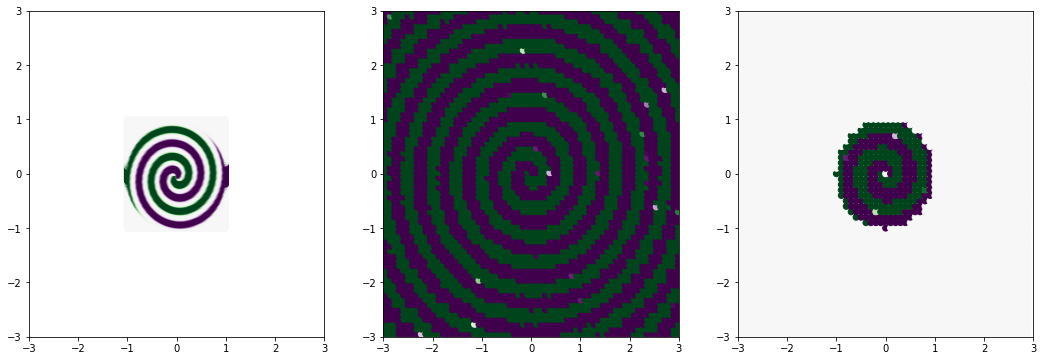

In [8]:
fig, ax = plt.subplots(1,3,figsize=(6*3,6))
ax[0].scatter(ns[:,1],ns[:,2],c=1-ns[:,0], cmap='PRGn')
ax[1].scatter(ms[:,0],ms[:,1],c=ms[:,2], cmap='PRGn')
ax[2].scatter(ib.truepst[1][2][0],ib.truepst[1][2][1],c=ib.truepst[1][2][2], cmap='PRGn')

for i in range(3):
    ax[i].set_xlim([-3,3])
    ax[i].set_ylim([-3,3])

#### Brute force coordinate search
Brute force fails to find corresponding coordinates

In [9]:
new_coor = []

for coor in ms:
    tmp = np.where(np.all(np.isclose(ns[:,1:], coor[0]), axis=1))

    if tmp[0]:
        new_coor.append(int(tmp[0]))

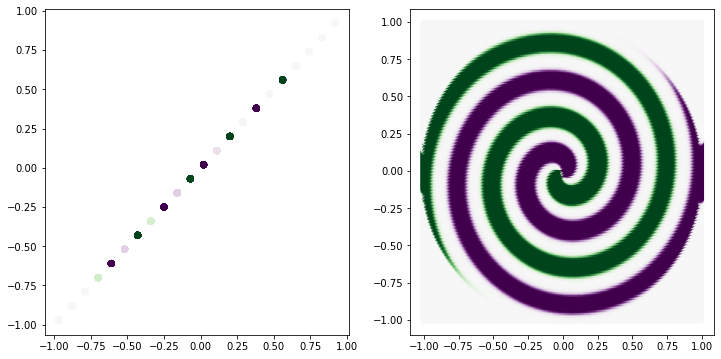

In [10]:
t = ns[new_coor]
fig, ax = plt.subplots(1,2,figsize=(6*2,6))
ax[0].scatter(t[:,1],t[:,2],c=1-t[:,0], cmap='PRGn')
ax[1].scatter(ns[:,1],ns[:,2],c=1-ns[:,0], cmap='PRGn')

#### Tree based nearest neighbor search

In [11]:
tree = spatial.cKDTree(ns[:,1:])

In [12]:
new_coor = []
for coor in ms:
    tmp = tree.query_ball_point(coor[:2], 0.02)
    if tmp:
        new_coor.append(tmp[0])

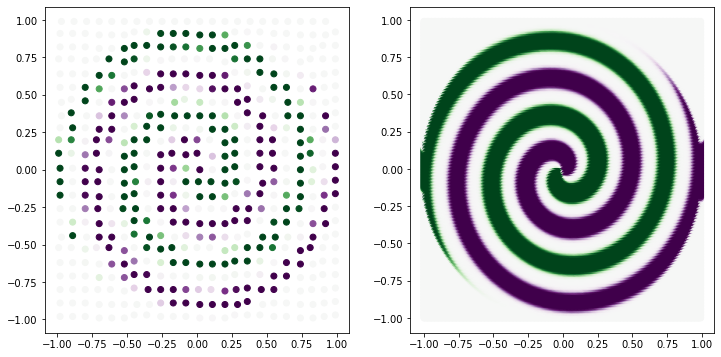

In [13]:
t = ns[new_coor]
fig, ax = plt.subplots(1,2,figsize=(6*2,6))
ax[0].scatter(t[:,1],t[:,2],c=1-t[:,0], cmap='PRGn')
ax[1].scatter(ns[:,1],ns[:,2],c=1-ns[:,0], cmap='PRGn')

#### Use tree based transfer of coordinate and impute extrapolative region

In [14]:
new_coor = []
for coor in ms:
    tmp = tree.query_ball_point(coor[:2], 0.02)
    if tmp:
        new_coor += [coor[:2].tolist() + [ns[tmp[0]][0]]]
    else:
        new_coor += [coor[:2].tolist() + [0.5]]

#### Pre-process new posterior

In [15]:
ib.mask = ib.generate_mask(h=0.1)
mtype_i = ib.pointwise_gridAverage(new_coor).to_numpy()
xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)

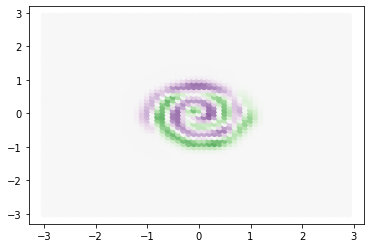

In [16]:
plt.scatter(xy[:,0], xy[:,1], c=alls, cmap='PRGn', vmin=0, vmax=1)